In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import *

In [275]:
df = pd.read_excel('TNT Case Data.xls', sheet_name='AP_Masked Data', header=0)
df.head()

,C.candidateId,Der.Age,C.personalDetails.gender,C.personalDetails.religion,C.personalDetails.caste,C.personalDetails.differentlyAbled,C.sourceOfMobilization.source,C.personalDetails.maritialStatus,C.contactDetails.district,ExpD.employedStatus,...,B.batchfees,AJD.jobName,AJD.nsqfLevel,AJD.qpCode,QPS.qpParamOne.paramDesc,QPS.qpParamThree.paramDesc,QPS.qpParamTwo.paramDesc,AJD.assmtCrt.percentage,AJD.assmtCrt.result,Der.CandidateFromAndra
0,1,20,MALE,Hindu,ST,NO,Self Registration,Unmarried,visakhapatanam,No,...,0,Manual Metal Arc Welding/ Shielded Metal Arc W...,3.0,QP-756,technical,organized,manufacturing,82.75,PASS,True
1,2,18,MALE,Hindu,SC,NO,Self Registration,Unmarried,cuddapah,No,...,0,Computer Hardware Assistant,3.0,QP-1430,non-technical,unorganized,manufacturing,57.00,PASS,True
2,3,20,MALE,Hindu,General,NO,Self Registration,Unmarried,cuddapah,No,...,0,Computer Hardware Assistant,3.0,QP-1430,non-technical,unorganized,manufacturing,87.00,PASS,True
3,4,22,MALE,Hindu,OBC,NO,Self Registration,Unmarried,cuddapah,No,...,0,Computer Hardware Assistant,3.0,QP-1430,non-technical,unorganized,manufacturing,66.00,PASS,True
4,5,22,MALE,Hindu,OBC,NO,Self Registration,Unmarried,cuddapah,No,...,0,Computer Hardware Assistant,3.0,QP-1430,non-technical,unorganized,manufacturing,80.00,PASS,True


In [276]:
df.dropna(inplace = True)

### 1. Use a boxplot to show the distribution of assessment scores per training provider ("B.tpId" represent the training provider id and "AJD.assmtCrt.percentage" represents the assessment score).

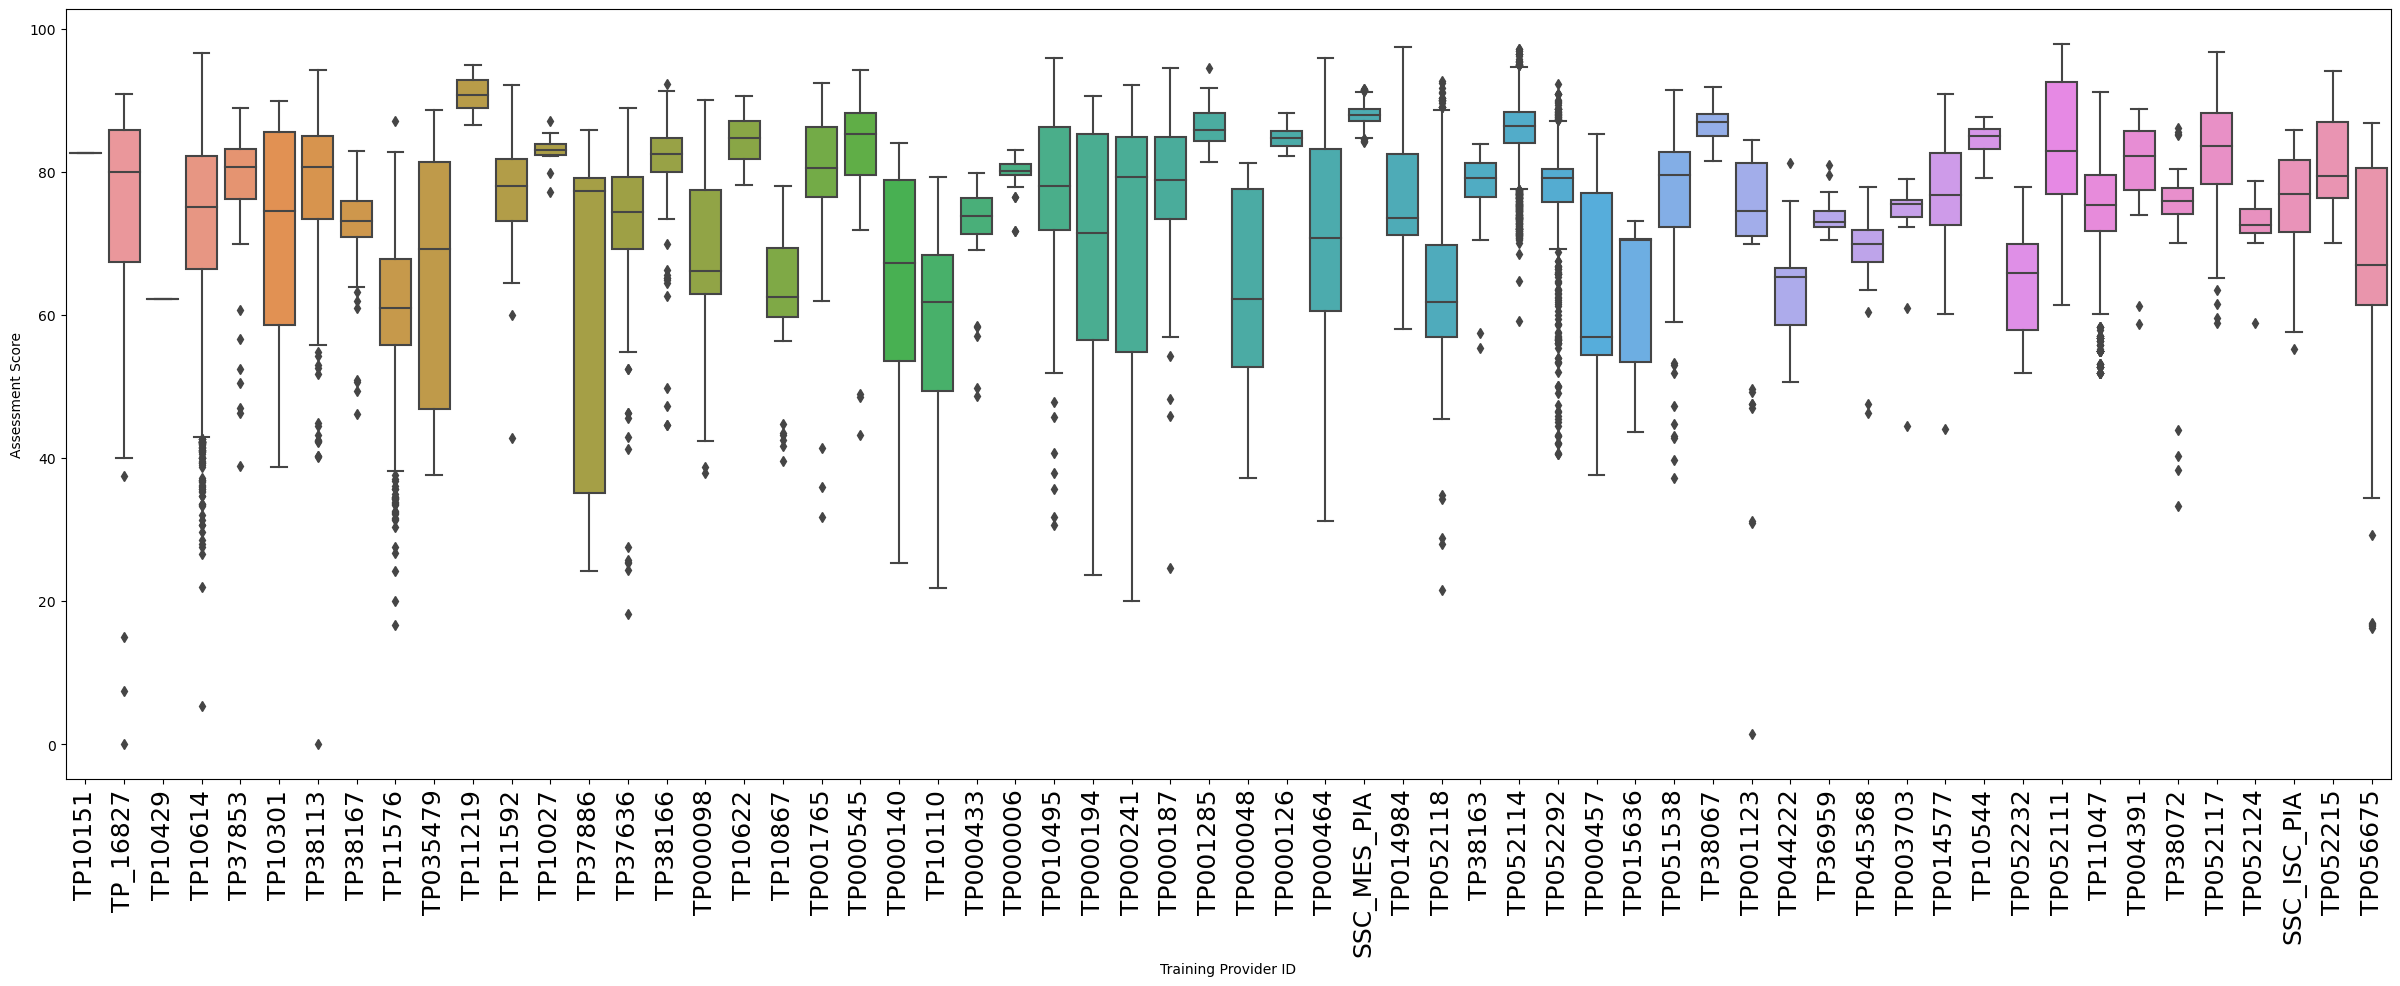

In [277]:
# Create the boxplot
plt.figure(figsize=(30, 10))

g = sns.boxplot(x='B.tpId', y='AJD.assmtCrt.percentage', data=df)
g.set(xlabel='Training Provider ID', ylabel='Assessment Score')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=18)

# Show the plot
plt.show()

### 2. Use a stacked bar plot to show the number of FAIL/PASS per training provider ("AJD.assmtCrt.result" represents the assessment status which is populated by FAIL/PASS)

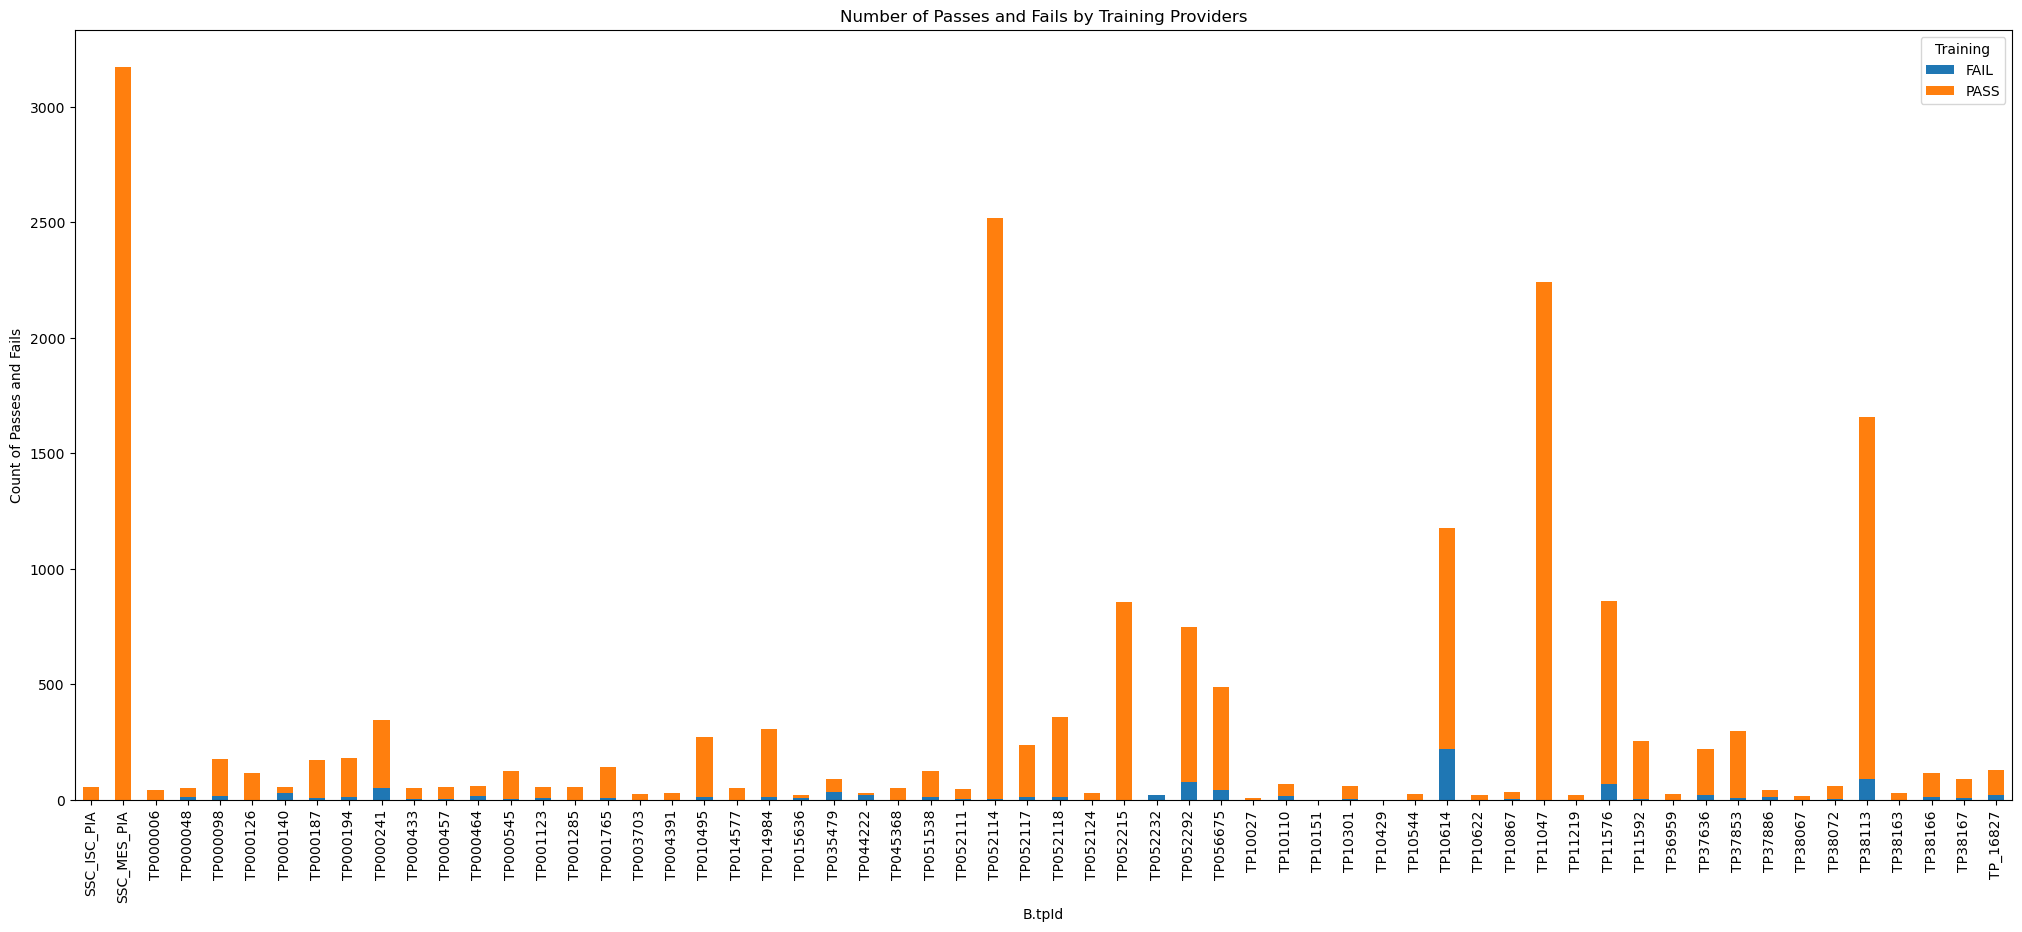

In [278]:
table = pd.crosstab(df['B.tpId'], df['AJD.assmtCrt.result'])
fig, ax = plt.subplots(figsize=(25,10))
table.plot.bar(stacked=True, ax=ax)

# Customize the appearance of the plot
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Count of Passes and Fails')
ax.set_title('Number of Passes and Fails by Training Providers')
ax.legend(title='Training')

# Display the plot
plt.show()

### 3. Count the number of unique "B.sector.name", "B.address.district.name", "B.batchName", and "C.candidateId" per training provider.

In [279]:
variable_list = ["B.sector.name", "B.address.district.name", "B.batchName", "C.candidateId"]
uni_num_dict = pd.DataFrame({'B.sector.name':[], 
                             'B.address.district.name':[], 'B.batchName':[], 
                             'C.candidateId':[]})
col_names = ['Unique Sector Name Count', 'Unique District Name Count', 'Unique Batch Name Count','Unique Candidate ID Count']

In [280]:
for p in df["B.tpId"].unique():
    for v in variable_list:
        uni_num_dict.loc[p, v] = int(df[df['B.tpId']==p][v].nunique())

In [281]:
uni_num_dict.sample(5)

,B.sector.name,B.address.district.name,B.batchName,C.candidateId
TP11047,1.0,6.0,46.0,2241.0
TP052111,1.0,1.0,2.0,47.0
TP38067,1.0,1.0,2.0,16.0
TP000194,2.0,2.0,7.0,183.0
TP004391,1.0,1.0,1.0,29.0


In [282]:
uni_num_dict.columns[0]

'B.sector.name'

### 4. Calculate the median of assessment score and percentage of candidates who pass the assessment test per training provider.

In [283]:
mscore_perct_dict = pd.DataFrame()

In [284]:
for p in df["B.tpId"].unique():
    mscore_perct_dict.loc[p, 'Assessment Score Median'] = df[df['B.tpId']==p]['AJD.assmtCrt.percentage'].median()
    total_num = len(df[df['B.tpId']==p]['AJD.assmtCrt.result'])
    pass_num = (df[df['B.tpId']==p]['AJD.assmtCrt.result']=='PASS').sum()
    mscore_perct_dict.loc[p, 'Pass Percentage'] = pass_num/total_num

In [285]:
mscore_perct_dict.head()

,Assessment Score Median,Pass Percentage
TP10151,82.75,1.000000
TP_16827,80.00,0.832061
TP10429,62.25,0.000000
TP10614,75.19,0.811064
TP37853,80.75,0.976431


### 5. Use the result of question 3 as inputs (4 inputs) and question 4 as outputs (2 outputs) of DEA model parameters. Solve the linear optimization problems per training provider given the set of inputs and output.

In [287]:
providers = df["B.tpId"].unique().tolist()

In [289]:
performance=dict()

In [290]:
# decision variables
output_Ingredients=['score_var', 'pass_var']
input_Ingredients=['sec_var','dist_var', 'batch_var', 'cand_var']

In [291]:
output_vars = LpVariable.dicts("O", output_Ingredients, 0)
input_vars = LpVariable.dicts("I", input_Ingredients, 0)

In [292]:
inputs = {}
for p in df["B.tpId"].unique():
    inputs[p] = {}
    j = 0
    for i in input_Ingredients:
        inputs[p][i] = int(uni_num_dict.loc[p, uni_num_dict.columns[j]])
        j += 1
    j = 0
    for o in output_Ingredients:
        inputs[p][o] = float(mscore_perct_dict.loc[p, mscore_perct_dict.columns[j]])
        j += 1


In [293]:
dual_solutions = {}
optimal_values = {}

In [294]:
for host in providers:
    prob = LpProblem("Training_Provider_Optimization", LpMaximize)

    #Objective 
    prob += (
        lpSum([inputs[host][i] * output_vars[i] for i in output_Ingredients]), "Performance Optimization for Provider",
    )


    for h in providers:
        prob += (
            lpSum([inputs[h][i] * output_vars[i] for i in output_Ingredients]+[-inputs[h][i] * input_vars[i] for i in input_Ingredients ]) <= 0,
            "{}".format(h)
        )

    #Constraints
    prob += lpSum([inputs[host][i] * input_vars[i] for i in input_Ingredients]) == 1, "Norm"        

    print("_____________________LP- Provider: {}_____________________".format(host))  
    print(prob)    

    prob.writeLP("DEA_Provider.{}_Model.lp".format(h))


    print("______________________Solution_________________________")
    optimal_values[host] = {}

    prob.solve()
    print("Status:", LpStatus[prob.status])


    for v in prob.variables():
        print(v.name, "=", v.varValue)
        optimal_values[host][v.name] = v.varValue



    print("Optimal Utilization of Provider {} = ".format(host), value(prob.objective))

    print("__________________________ Dual Variables _______________")
    
    dual_solutions[host] = {}

    for name, c in list(prob.constraints.items()):
        print(name, ":", "\t Dual:", c.pi  )
        dual_solutions[host][name] = c.pi
        
    performance[host]= value(prob.objective) 

_____________________LP- Provider: TP10151_____________________
Training_Provider_Optimization:
MAXIMIZE
1.0*O_pass_var + 82.75*O_score_var + 0.0
SUBJECT TO
TP10151: - I_batch_var - I_cand_var - I_dist_var - I_sec_var + O_pass_var
 + 82.75 O_score_var <= 0

TP_16827: - 2 I_batch_var - 131 I_cand_var - I_dist_var - 2 I_sec_var
 + 0.832061068702 O_pass_var + 80 O_score_var <= 0

TP10429: - I_batch_var - I_cand_var - I_dist_var - I_sec_var
 + 62.25 O_score_var <= 0

TP10614: - 58 I_batch_var - 1175 I_cand_var - I_dist_var - 9 I_sec_var
 + 0.811063829787 O_pass_var + 75.19 O_score_var <= 0

TP37853: - 8 I_batch_var - 297 I_cand_var - 2 I_dist_var - 2 I_sec_var
 + 0.976430976431 O_pass_var + 80.75 O_score_var <= 0

TP10301: - 2 I_batch_var - 60 I_cand_var - 2 I_dist_var - 2 I_sec_var
 + 0.95 O_pass_var + 74.585 O_score_var <= 0

TP38113: - 31 I_batch_var - 1658 I_cand_var - 2 I_dist_var - I_sec_var
 + 0.945717732207 O_pass_var + 80.75 O_score_var <= 0

TP38167: - 3 I_batch_var - 89 I_cand_v

Status: Optimal
I_batch_var = 0.0
I_cand_var = 0.0
I_dist_var = 0.0
I_sec_var = 1.0
O_pass_var = 0.0
O_score_var = 0.0110011
Optimal Utilization of Provider TP11219 =  0.9999999900000001
__________________________ Dual Variables _______________
TP10151 : 	 Dual: -0.0
TP_16827 : 	 Dual: -0.0
TP10429 : 	 Dual: -0.0
TP10614 : 	 Dual: -0.0
TP37853 : 	 Dual: -0.0
TP10301 : 	 Dual: -0.0
TP38113 : 	 Dual: -0.0
TP38167 : 	 Dual: -0.0
TP11576 : 	 Dual: -0.0
TP035479 : 	 Dual: -0.0
TP11219 : 	 Dual: 1.0
TP11592 : 	 Dual: -0.0
TP10027 : 	 Dual: -0.0
TP37886 : 	 Dual: -0.0
TP37636 : 	 Dual: -0.0
TP38166 : 	 Dual: -0.0
TP000098 : 	 Dual: -0.0
TP10622 : 	 Dual: -0.0
TP10867 : 	 Dual: -0.0
TP001765 : 	 Dual: -0.0
TP000545 : 	 Dual: -0.0
TP000140 : 	 Dual: -0.0
TP10110 : 	 Dual: -0.0
TP000433 : 	 Dual: -0.0
TP000006 : 	 Dual: -0.0
TP010495 : 	 Dual: -0.0
TP000194 : 	 Dual: -0.0
TP000241 : 	 Dual: -0.0
TP000187 : 	 Dual: -0.0
TP001285 : 	 Dual: -0.0
TP000048 : 	 Dual: -0.0
TP000126 : 	 Dual: -0.0
TP000

______________________Solution_________________________
Status: Optimal
I_batch_var = 0.0
I_cand_var = 0.0
I_dist_var = 1.0
I_sec_var = 0.0
O_pass_var = 0.0
O_score_var = 0.0110011
Optimal Utilization of Provider TP000140 =  0.7407040629999999
__________________________ Dual Variables _______________
TP10151 : 	 Dual: -0.0
TP_16827 : 	 Dual: -0.0
TP10429 : 	 Dual: -0.0
TP10614 : 	 Dual: -0.0
TP37853 : 	 Dual: -0.0
TP10301 : 	 Dual: -0.0
TP38113 : 	 Dual: -0.0
TP38167 : 	 Dual: -0.0
TP11576 : 	 Dual: -0.0
TP035479 : 	 Dual: -0.0
TP11219 : 	 Dual: 0.74070407
TP11592 : 	 Dual: -0.0
TP10027 : 	 Dual: -0.0
TP37886 : 	 Dual: -0.0
TP37636 : 	 Dual: -0.0
TP38166 : 	 Dual: -0.0
TP000098 : 	 Dual: -0.0
TP10622 : 	 Dual: -0.0
TP10867 : 	 Dual: -0.0
TP001765 : 	 Dual: -0.0
TP000545 : 	 Dual: -0.0
TP000140 : 	 Dual: -0.0
TP10110 : 	 Dual: -0.0
TP000433 : 	 Dual: -0.0
TP000006 : 	 Dual: -0.0
TP010495 : 	 Dual: -0.0
TP000194 : 	 Dual: -0.0
TP000241 : 	 Dual: -0.0
TP000187 : 	 Dual: -0.0
TP001285 : 	 

Status: Optimal
I_batch_var = 0.0
I_cand_var = 0.0
I_dist_var = 0.0
I_sec_var = 0.5
O_pass_var = 0.0
O_score_var = 0.0055005501
Optimal Utilization of Provider TP000464 =  0.389768980086
__________________________ Dual Variables _______________
TP10151 : 	 Dual: -0.0
TP_16827 : 	 Dual: -0.0
TP10429 : 	 Dual: -0.0
TP10614 : 	 Dual: -0.0
TP37853 : 	 Dual: -0.0
TP10301 : 	 Dual: -0.0
TP38113 : 	 Dual: -0.0
TP38167 : 	 Dual: -0.0
TP11576 : 	 Dual: -0.0
TP035479 : 	 Dual: -0.0
TP11219 : 	 Dual: 0.77953795
TP11592 : 	 Dual: -0.0
TP10027 : 	 Dual: -0.0
TP37886 : 	 Dual: -0.0
TP37636 : 	 Dual: -0.0
TP38166 : 	 Dual: -0.0
TP000098 : 	 Dual: -0.0
TP10622 : 	 Dual: -0.0
TP10867 : 	 Dual: -0.0
TP001765 : 	 Dual: -0.0
TP000545 : 	 Dual: -0.0
TP000140 : 	 Dual: -0.0
TP10110 : 	 Dual: -0.0
TP000433 : 	 Dual: -0.0
TP000006 : 	 Dual: -0.0
TP010495 : 	 Dual: -0.0
TP000194 : 	 Dual: -0.0
TP000241 : 	 Dual: -0.0
TP000187 : 	 Dual: -0.0
TP001285 : 	 Dual: -0.0
TP000048 : 	 Dual: -0.0
TP000126 : 	 Dual: -0.

Status: Optimal
I_batch_var = 0.0
I_cand_var = 0.0
I_dist_var = 0.0
I_sec_var = 1.0
O_pass_var = 1.0
O_score_var = 0.0
Optimal Utilization of Provider TP001123 =  0.8620689655172413
__________________________ Dual Variables _______________
TP10151 : 	 Dual: -0.0
TP_16827 : 	 Dual: -0.0
TP10429 : 	 Dual: -0.0
TP10614 : 	 Dual: -0.0
TP37853 : 	 Dual: -0.0
TP10301 : 	 Dual: -0.0
TP38113 : 	 Dual: -0.0
TP38167 : 	 Dual: -0.0
TP11576 : 	 Dual: -0.0
TP035479 : 	 Dual: -0.0
TP11219 : 	 Dual: 0.64858952
TP11592 : 	 Dual: -0.0
TP10027 : 	 Dual: -0.0
TP37886 : 	 Dual: -0.0
TP37636 : 	 Dual: -0.0
TP38166 : 	 Dual: -0.0
TP000098 : 	 Dual: -0.0
TP10622 : 	 Dual: -0.0
TP10867 : 	 Dual: -0.0
TP001765 : 	 Dual: -0.0
TP000545 : 	 Dual: -0.0
TP000140 : 	 Dual: -0.0
TP10110 : 	 Dual: -0.0
TP000433 : 	 Dual: -0.0
TP000006 : 	 Dual: -0.0
TP010495 : 	 Dual: -0.0
TP000194 : 	 Dual: -0.0
TP000241 : 	 Dual: -0.0
TP000187 : 	 Dual: -0.0
TP001285 : 	 Dual: -0.0
TP000048 : 	 Dual: -0.0
TP000126 : 	 Dual: -0.0
TP0

______________________Solution_________________________
Status: Optimal
I_batch_var = 0.0
I_cand_var = 0.0
I_dist_var = 0.0
I_sec_var = 1.0
O_pass_var = 1.0
O_score_var = 0.0
Optimal Utilization of Provider TP004391 =  0.9310344827586207
__________________________ Dual Variables _______________
TP10151 : 	 Dual: -0.0
TP_16827 : 	 Dual: -0.0
TP10429 : 	 Dual: -0.0
TP10614 : 	 Dual: -0.0
TP37853 : 	 Dual: -0.0
TP10301 : 	 Dual: -0.0
TP38113 : 	 Dual: -0.0
TP38167 : 	 Dual: -0.0
TP11576 : 	 Dual: -0.0
TP035479 : 	 Dual: -0.0
TP11219 : 	 Dual: 0.80351991
TP11592 : 	 Dual: -0.0
TP10027 : 	 Dual: -0.0
TP37886 : 	 Dual: -0.0
TP37636 : 	 Dual: -0.0
TP38166 : 	 Dual: -0.0
TP000098 : 	 Dual: -0.0
TP10622 : 	 Dual: -0.0
TP10867 : 	 Dual: -0.0
TP001765 : 	 Dual: -0.0
TP000545 : 	 Dual: -0.0
TP000140 : 	 Dual: -0.0
TP10110 : 	 Dual: -0.0
TP000433 : 	 Dual: -0.0
TP000006 : 	 Dual: -0.0
TP010495 : 	 Dual: -0.0
TP000194 : 	 Dual: -0.0
TP000241 : 	 Dual: -0.0
TP000187 : 	 Dual: -0.0
TP001285 : 	 Dual: 

### 6. Based on the results, identify low and top-efficient training providers.

In [295]:
top_p = []
for p, ultilization in performance.items():
    if ultilization >= 0.99:
        top_p.append(p) 

The top efficient training providers are listed below in the top_p list. Providers with efficiency of almost 1 are identified as top-efficient traning providers.

In [296]:
top_p

['TP10151',
 'TP11219',
 'TP10027',
 'TP10622',
 'TP000006',
 'TP001285',
 'TP000126',
 'SSC_MES_PIA',
 'TP052114',
 'TP38067',
 'TP36959',
 'TP10544',
 'TP11047',
 'SSC_ISC_PIA',
 'TP052215']

The low-efficient training providers are listed below in the table called low_p along with their ultilization. Providers with efficiency ranked to be at the bottom five are identified to be low-efficient traning providers.

In [297]:
low_p = pd.DataFrame.from_dict(performance, orient='index').sort_values(by=[0], ascending=True).rename(columns={0: 'Ultilization'}).head(5)
low_p

,Ultilization
TP010495,0.238051
TP37636,0.303167
TP000187,0.315992
TP000545,0.325333
TP000048,0.386792


### 7. Based on the DEA results, identify different approaches that can be deployed to make the skilling ecosystem more efficient.

In [299]:
dual_solutions_low_p = {}

In [300]:
for p in low_p.index:
    dual_solutions_low_p[p] = {}
    for provider, value in dual_solutions[p].items():
        if value > 0 and provider != 'Norm':
            dual_solutions_low_p[p][provider] = value

In [302]:
improvements = {}
decreases = {}

In [303]:
for provider, solution in dual_solutions_low_p.items():
    improvements[provider] = {}
    
    orig_sec_var = inputs[provider]['sec_var']
    orig_dist_var = inputs[provider]['dist_var']
    orig_batch_var = inputs[provider]['batch_var']
    orig_cand_var = inputs[provider]['cand_var']
    
    decrease_sec_var = (1-low_p.loc[provider, 'Ultilization'])/optimal_values[provider]['I_sec_var']
    decrease_dist_var = (1-low_p.loc[provider, 'Ultilization'])/optimal_values[provider]['I_dist_var']
    decrease_batch_var = (1-low_p.loc[provider, 'Ultilization'])/optimal_values[provider]['I_batch_var']
    decrease_cand_var = (1-low_p.loc[provider, 'Ultilization'])/optimal_values[provider]['I_cand_var']
    
    temp_sec_var = 0
    temp_dist_var = 0
    temp_batch_var = 0
    temp_cand_var = 0
    
    for k, v in solution.items():
        temp_sec_var = inputs[k]['sec_var'] * v + temp_sec_var
        temp_dist_var = inputs[k]['dist_var'] * v + temp_dist_var
        temp_batch_var = inputs[k]['batch_var'] * v + temp_batch_var
        temp_cand_var = inputs[k]['cand_var'] * v + temp_cand_var
        
    excess_sec_var = orig_sec_var - temp_sec_var
    excess_dist_var = orig_dist_var - temp_dist_var
    excess_batch_var = orig_batch_var - temp_batch_var
    excess_cand_var = orig_cand_var - temp_cand_var
    
    improvements[provider] = {'excess_sec_var': excess_sec_var,
                             'excess_dist_var': excess_dist_var,
                             'excess_batch_var': excess_batch_var,
                             'excess_cand_var': excess_cand_var}
    
    decreases[provider] = {'decrease_sec_var': decrease_sec_var,
                             'decrease_dist_var': decrease_dist_var,
                             'decrease_batch_var': decrease_batch_var,
                             'decrease_cand_var': decrease_cand_var}

C:\Users\ddjgy\AppData\Local\Temp\ipykernel_37720\1568953436.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  decrease_dist_var = (1-low_p.loc[provider, 'Ultilization'])/optimal_values[provider]['I_dist_var']
C:\Users\ddjgy\AppData\Local\Temp\ipykernel_37720\1568953436.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  decrease_batch_var = (1-low_p.loc[provider, 'Ultilization'])/optimal_values[provider]['I_batch_var']
C:\Users\ddjgy\AppData\Local\Temp\ipykernel_37720\1568953436.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  decrease_cand_var = (1-low_p.loc[provider, 'Ultilization'])/optimal_values[provider]['I_cand_var']
C:\Users\ddjgy\AppData\Local\Temp\ipykernel_37720\1568953436.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  decrease_sec_var = (1-low_p.loc[provider, 'Ultilization'])/optimal_values[provider]['I_sec_var']


In [305]:
decreases

{'TP010495': {'decrease_sec_var': 3.047794117647059,
  'decrease_dist_var': inf,
  'decrease_batch_var': inf,
  'decrease_cand_var': inf},
 'TP37636': {'decrease_sec_var': inf,
  'decrease_dist_var': 2.0904977675565615,
  'decrease_batch_var': inf,
  'decrease_cand_var': inf},
 'TP000187': {'decrease_sec_var': 2.0520231513872838,
  'decrease_dist_var': inf,
  'decrease_batch_var': inf,
  'decrease_cand_var': inf},
 'TP000545': {'decrease_sec_var': 2.0240000300000003,
  'decrease_dist_var': inf,
  'decrease_batch_var': inf,
  'decrease_cand_var': inf},
 'TP000048': {'decrease_sec_var': 1.2264150954442496,
  'decrease_dist_var': inf,
  'decrease_batch_var': 4119918159.7745657,
  'decrease_cand_var': -178226341797.0984}}

The following table shows how much excess each input has for the five low-efficient providers. In order to improve the efficiency, the following approaches can be used to increase the efficiency for the low-efficient providers.
- reduce the number of sectors that the provider provides services to
- restrict the number of districts the provider operates in
- decrease the number of batches
- reduce the numebr of candidates


In [309]:
pd.DataFrame(improvements)

,TP010495,TP37636,TP000187,TP000545,TP000048
excess_sec_var,3.047794,3.484163,2.052023,2.024000,1.226415
excess_dist_var,3.047794,2.090498,4.052023,2.024000,1.226415
excess_batch_var,9.047794,5.484163,5.052023,4.024000,1.226415
excess_cand_var,249.631395,178.894546,150.921415,102.974086,32.500000
